In [1]:
import evaluate_pose
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

from core import *
from utils import phantom_builder
from utils import geometry

In [3]:
import eva_image_quality

In [91]:
import json
json_data = open('results1.json')
res = json.load(json_data)

In [92]:
# evaluation
optimal_parameters = res['X']
optimal_quality = -np.array(res['F'])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(res['history'])
plt.xlabel("Generation")
plt.ylabel("Objective Value")
plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pymoo

# from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.operators.sampling.rnd import FloatRandomSampling
# from pymoo.operators.crossover.sbx import SBX
# from pymoo.operators.mutation.pm import PolynomialMutation

# Other modules
# import json
# from IPython.display import HTML
# import matplotlib.animation as animation

In [ ]:
# # TODO: modify for path planning
# from pymoo.core.problem import ElementwiseProblem

# class pose_optimization(ElementwiseProblem):

#     # When intializing get the mechanism structure which is being optimized
#     #(not the initial positions as we are trying to find those)
#     def __init__(self,C,fixed_nodes,motor,target_point_cloud):

#         # set the problem paramters(n_var = number of parameters(number of nodes * 2),
#         # n_obj=number of objectives, xl=lower bound for the parameters, xu=upper bound for the paramters)
#         super().__init__(n_var = C.shape[0] * 2, n_obj=1, xl=0.0, xu=2.0, elementwise_evaluation=True)

#         # Store mechanism information for later
#         self.C = C
#         self.fixed_nodes = fixed_nodes
#         self.motor = motor
#         self.N = C.shape[0]

#         # Store the target curve point cloud
#         self.tpc = target_point_cloud


#     def _evaluate(self, x, out, *args, **kwargs):
#         x0 = np.array(x.reshape([self.N,2]))  #reshape the flattened vector that comes in into 2D array

#         # Simulate
#         valid, CD, mat, _ = evaluate_mechanism(self.C,x0,self.fixed_nodes, self.motor, self.tpc, idx=None,device='cpu',timesteps=2000)
#         # valid, CD, mat, CD_grad,mat_grad,g_c = functions_and_gradients(C,x0,fixed_nodes, target_curve, motor)

#         # check to see if the mechanism is valid
#         if not valid:
#             # if mechanism is invalid set the objective to infinity
#             out["F"] = np.Inf
#         else:
#             # Send the chamfer distance to pymoo as objective
#             out["F"] = CD

In [ ]:
# # Setup an instance of our problem
# problem = mechanism_optimization(C,fixed_nodes,motor,target_curve)

# # Setup the algorithm
# algorithm = NSGA2(pop_size=30,
#                   sampling=FloatRandomSampling(),
#                   crossover=SBX(prob=1.0, eta=3.0),
#                   mutation=PolynomialMutation(eta=3.0, prob=0.05),
#                   eliminate_duplicates=True)

In [ ]:
# from pymoo.optimize import minimize
# results = minimize(problem,
#                    algorithm,
#                    ('n_gen', 50),
#                    verbose=True,
#                    save_history=True,
#                    seed=3,
#                    display=best())

In [11]:
# np.random.seed(8888)
pose_eva = evaluate_pose.PoseEvaluator()

Added fat
Added muscle
Added muscle
Added bone
Added connective_tissue
Added renal_cortex
Added blood
Added blood
Added renal_medulla


In [ ]:
# normal = np.array([0, 0, 0])
# pt = np.array([0, 0, 0])
# pose = geometry.Transform.make_from_heading_vector(normal, pt)
# pose = [pt, normal]
max_ite = 1
for i in range(max_ite):
    pt = ((np.random.rand(1,3)-0.5) * 0.03).squeeze()
    normal = (np.random.rand(1,3)-0.5).squeeze()
    pose = [pt, normal]
    print(f"get new pose {pose}")
    pose_list = [pose]
    images = pose_eva.run_pose(pose_list)
    matrics = pose_eva.evaluate_images(images)
    print(matrics)

In [28]:
pose_list[0]

[array([0.0117656 , 0.01004597, 0.01046934]),
 array([ 0.34440839,  0.39439446, -0.47272222])]

In [ ]:
num_transducers = len(pose_list)
transducers = [transducer.Planewave(max_frequency=1e6,
                                    elements = 16, 
                                    width = 40e-3,
                                    height =  20e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/6,
                                    ray_num = 8, 
                                    imaging_ndims = 2,
                                    focus_elevation = 20e-3,
                                    ) for i in range(num_transducers)]
for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
pt, normal = test_transducer_set.place_on_mesh_voxel(0, pose_eva.surface_mesh, pose_diff[0], pose_eva.voxel_size[0])

In [16]:
pt

array([[-0.01217367, -0.01829934, -0.044065  ]], dtype=float32)

In [65]:
import open3d as o3d
voxel_size = np.array([0.0005, 0.0005, 0.0005])
# segmentation/MUSiK/assets/kidney_phantom/02_muscle_2.obj
surface_mesh = o3d.io.read_triangle_mesh(f"{parent}/assets/kidney_phantom/08_VH_M_renal_papilla_L_i.obj")
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh)
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=1.3, scale=0.00001, label=1)
medulla = tissue.Tissue(name='renal_medulla', c=1564, rho=1044, sigma=40, scale=0.0001, label=2)
cortex = tissue.Tissue(name='renal_cortex', c=1571.3, rho=1049, sigma=5, scale=0.0001, label=3)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=0, scale=1, label=4)
connective = tissue.Tissue(name='connective_tissue', c=1450, rho=1027, sigma=30, scale=0.0001, label=5)
muscle = tissue.Tissue(name='muscle', c=1580, rho=1090, sigma=0, scale=0.0001, label=6)
bone = tissue.Tissue(name='bone', c=2500, rho=1800, sigma=0, scale=0.0001, label=7)
# skin = tissue.Tissue(name='skin', c=1624, rho=1109, sigma=1.3, scale=0.00001, label=8)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=0, scale=1, label=9)

kidney_file_dir = f"{parent}/assets/kidney_phantom/"
kidney_tissue_list = [fat, muscle, muscle, bone, connective, cortex, blood, blood, medulla]

# test_phantom.add_tissue(fat, mask=np.ones(test_phantom.matrix_dims))
test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], kidney_tissue_list, dir_path = kidney_file_dir)
test_phantom.set_default_tissue('water')

Added fat
Added muscle
Added muscle
Added bone
Added connective_tissue
Added renal_cortex
Added blood
Added blood
Added renal_medulla


In [6]:
pose_eva.test_phantom.get_complete().shape

(2, 52, 66, 112)

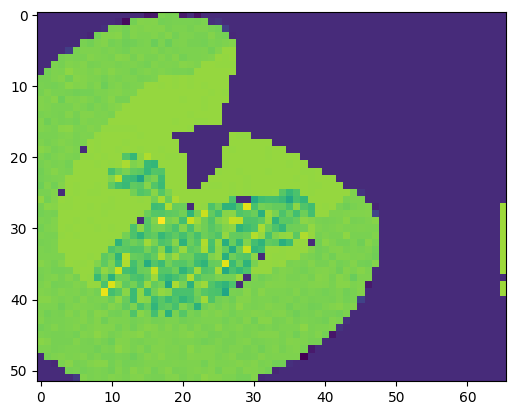

In [14]:
import matplotlib.pyplot as plt
plt.imshow(pose_eva.test_phantom.get_complete()[0, :, :, 50])
# plt.imshow(body_mask[:,:, 100] * 1000, alpha=0.2, cmap='Reds_r')

# plt.imshow(body_mask[:,:, 100])

In [4]:
path = "../../experiment_files/kidney_experiment_opt8_9/"

## Process Images

In [5]:
import numpy as np

# image_zip = np.load("../../experiment_files/kidney_experiment_opt2/99/image.npz")
# image = image_zip['image'].squeeze()
# pose = image_zip['pose']
# metrics = eva_image_quality.evaluate_image_quality(image)

In [15]:
metrics

[150.2516273827221, -1.2800668172432936, 3.751534750277052, 13.489441877174801]

In [6]:
image_list = []
pose_list = []
for dir in os.listdir(path):
    image_path = os.path.join(path, dir, "image.npz")
    if os.path.isfile(image_path):
        image_zip = np.load(image_path)
        image = image_zip['image']
        pose = image_zip['pose']
        image_list.append(image)
        pose_list.append(pose)

In [7]:
len(pose_list)

82

In [20]:
# normal = pose_list[0][0][0]
# pt = pose_list[0][0][1]
# test_pose = geometry.Transform.make_from_heading_vector(normal, pt)

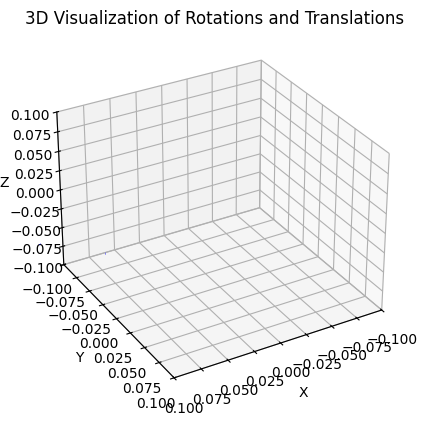

In [8]:
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=60)

for pose in pose_list:
    test_pose = geometry.Transform.make_from_heading_vector(pose[0][1], pose[0][0])
    rotation = test_pose.rotation
    translation = test_pose.translation
    direction = rotation.apply([1, 0, 0])  # [1, 0, 0] can represent the local x-axis direction after rotation
    
    # Plotting the arrow from the translation point in the direction of the rotation
    ax.quiver(
        translation[0], translation[1], translation[2],  # Start point of the arrow (translation)
        direction[0], direction[1], direction[2],        # Direction of the arrow (rotation applied)
        length=0.01, color='b'                              # Customize length and color as needed
    )

# Set plot limits and labels
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.1, 0.1])
ax.set_zlim([-0.1, 0.1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("3D Visualization of Rotations and Translations")

plt.show()

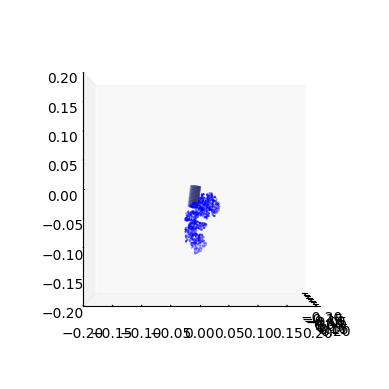

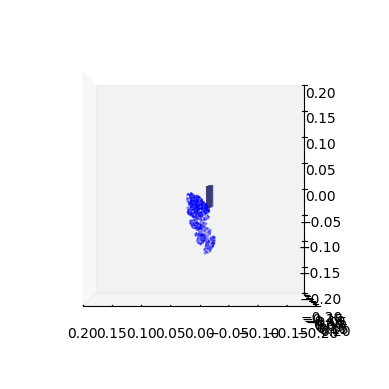

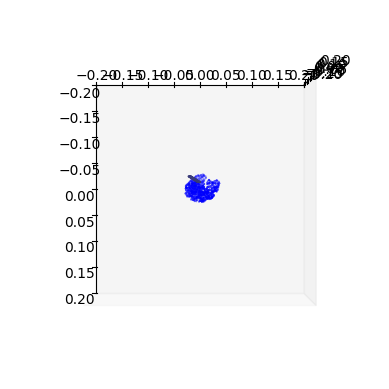

In [30]:
# pose_diff = pose_list[99][0]
# num_transducers = len(pose_list)
num_transducers = 1
transducers = [transducer.Planewave(max_frequency=1e6,
                                    elements = 16, 
                                    width = 40e-3,
                                    height =  20e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/6,
                                    ray_num = 8, 
                                    imaging_ndims = 2,
                                    focus_elevation = 20e-3,
                                    ) for i in range(num_transducers)]
for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]
        
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
# pt, normal = test_transducer_set.place_on_mesh_voxel(0, pose_eva.surface_mesh,[240,70,330], pose_eva.voxel_size[0])
# pt = np.array([pt[0], pt[1], pt[2]])
# normal = -np.array([normal[0] - 0.1, normal[1] - 0.5, normal[2] + 0.3])
theta = np.pi/2

# for i in range(num_transducers):
for i in range(1):
    pose_diff = pose_list[pareto_indices[5]][0]
    pt, normal = test_transducer_set.place_on_mesh_voxel(0, pose_eva.surface_mesh, pose_diff[0], pose_eva.voxel_size[0])
    pt = np.array([pt[0], pt[1], pt[2]])
    normal = -np.array([normal[0], normal[1], normal[2]]) + pose_diff[1]
    about_nl_axis = geometry.Transform(rotation=tuple(theta*normal), translation=(0, 0, 0), about_axis=True)
    pose = geometry.Transform.make_from_heading_vector(normal, pt)
    transducer_pose = about_nl_axis * pose
    test_transducer_set.assign_pose(i, transducer_pose)

points = np.array(pose_eva.surface_mesh.sample_points_uniformly(1000).points)
points = points[:,[0,1,2]] - np.mean(points, axis=0)

test_transducer_set.plot_transducer_coords(scale = 0.2, phantom_coords = points, view=(0,0))
test_transducer_set.plot_transducer_coords(scale = 0.2, phantom_coords = points, view=(0,90))
test_transducer_set.plot_transducer_coords(scale = 0.2, phantom_coords = points, view=(90,0))

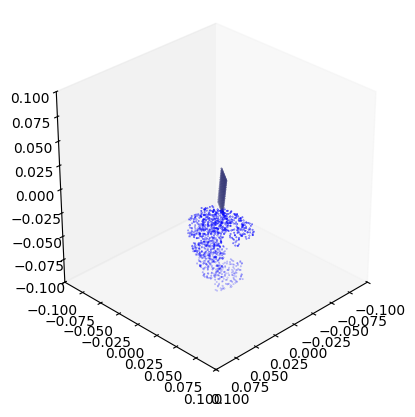

In [31]:

test_transducer_set.plot_transducer_coords(scale = 0.1, phantom_coords = points, view=(30,45))

In [16]:
from eva_image_quality import *

metric_list = []
for image in image_list:
    metric_eva = evaluate_image_quality(image.squeeze())
    metric_list.append(metric_eva)

In [17]:
def is_dominated(point, others):
    """
    Check if a point is dominated by any points in the 'others' array.
    """
    return np.any(np.all(others <= point, axis=1) & np.any(others < point, axis=1))

def find_pareto_indices(data):
    """
    Find the indices of the Pareto front from a set of multi-objective points.
    Returns the indices of Pareto front points.
    """
    pareto_indices = []
    for i, point in enumerate(data):
        # Remove the current point from the comparison set
        others = np.delete(data, i, axis=0)
        if not is_dominated(point, others):
            pareto_indices.append(i)
    return pareto_indices

pareto_indices = find_pareto_indices(metric_list)

In [18]:
len(pareto_indices)

64

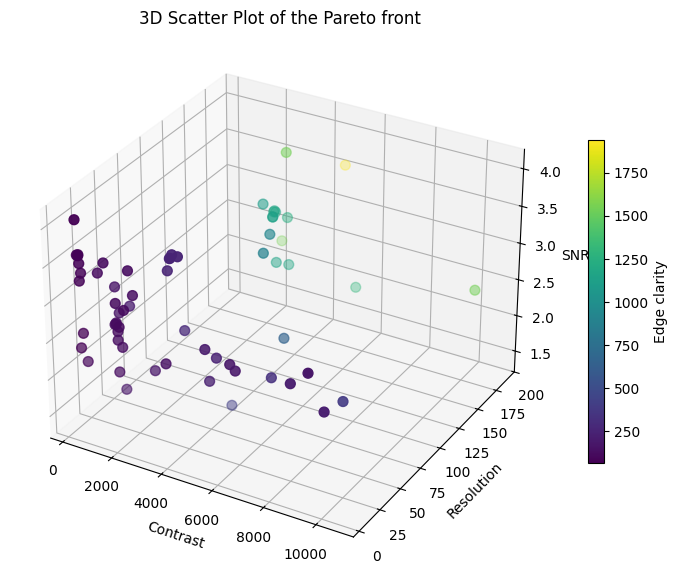

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

metric_list = np.array(metric_list)
# Extract metrics for plotting
metric_1 = metric_list[pareto_indices, 0]
metric_2 = -metric_list[pareto_indices, 1]
metric_3 = metric_list[pareto_indices, 2]
metric_4 = metric_list[pareto_indices, 3]

# 3D Scatter Plot (first three metrics)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(metric_1, metric_2, metric_3, c=metric_4, cmap='viridis', s=50)

# Add color bar to represent the fourth metric
color_bar = plt.colorbar(scatter, ax=ax, shrink=0.6)
color_bar.set_label('Edge clarity')

# Labels and title
ax.set_xlabel('Contrast')
ax.set_ylabel('Resolution')
ax.set_zlabel('SNR')
ax.set_title('3D Scatter Plot of the Pareto front')

# Show the plot
plt.show()

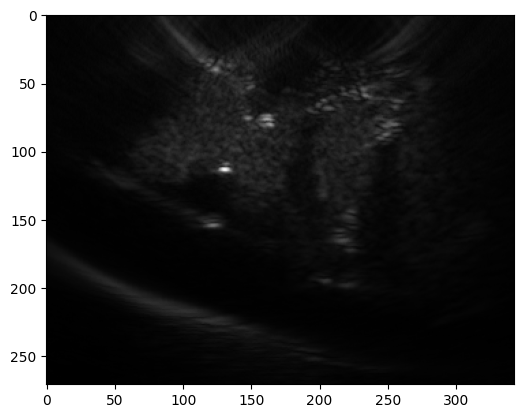

In [29]:
import matplotlib.pyplot as plt

# plt.imshow(image_list[60], cmap='gray')
plt.imshow(image_list[pareto_indices[5]], cmap='gray')
plt.show()
# plt.savefig('kidney_example.png', bbox_inches='tight')
# plt.close()

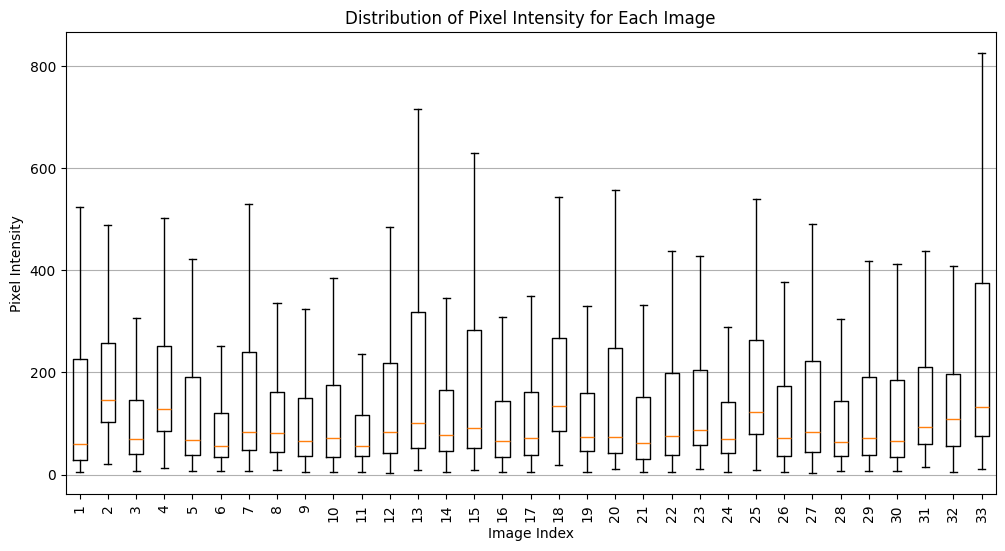

In [29]:
# Flatten each image to get all pixel values in a single list
pixel_values = [img.flatten() for img in image_list]  # Flatten each image for box plot

# Plot the box plot for each image
plt.figure(figsize=(12, 6))
plt.boxplot(pixel_values, showfliers=False)  # Set showfliers=False to hide outliers if desired
plt.xlabel("Image Index")
plt.ylabel("Pixel Intensity")
plt.title("Distribution of Pixel Intensity for Each Image")
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

In [19]:
np.max(image_list)

54361.728271484375